In [1]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

from xclim.indicators.atmos import relative_humidity_from_dewpoint
xn, xx, yn, yx = [125,146,30,46]

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/korea-fires/"

mapproj = cartopy.crs.PlateCarree()

In [124]:
sf_korea = gpd.read_file("sf_korea")
sf_ekorea = gpd.read_file("sf_ekorea")
sf_kyushu = gpd.read_file("sf_kyushu")

# Define region for download

In [2]:
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["South Korea", "Japan"]]

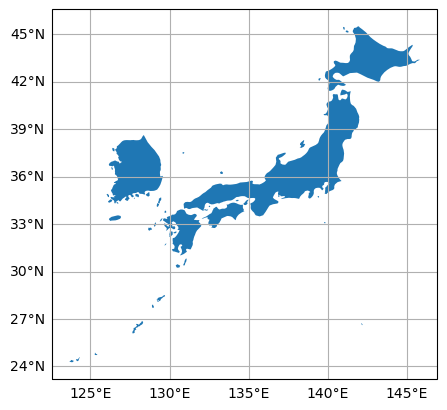

In [3]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj})#, "extent" : [125,146,30,46]})

rm.plot(ax = ax)
ax.gridlines(draw_labels = ["left", "bottom"])

In [14]:
kr = main_polygon(rm.loc[["South Korea"]])
kr.to_file("sf_korea")

In [15]:
jp = main_polygon(rm.loc[["Japan"]].explode(index_parts = True).clip((125,30,132,34)))
jp.to_file("sf_kyushu")

In [16]:
adm1 = gpd.read_file("sf_adm1").set_index("name")
sf_ekorea = main_polygon(adm1.loc[["South Gyeongsang", "North Gyeongsang", "Daegu", "Ulsan", "Busan"]])#
sf_ekorea.to_file("sf_ekorea")

/rds/general/user/cb2714/home/wwa/wwa.py:404: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf = gdf.loc[gdf.geometry.area == gdf.geometry.area.max()]


<AxesSubplot: >

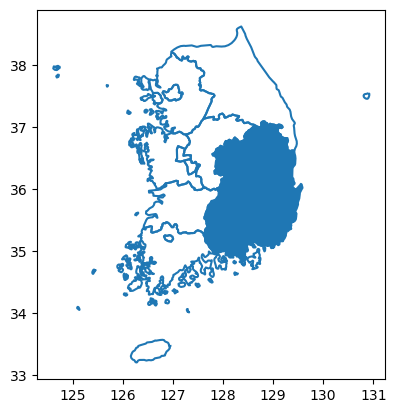

In [17]:
adm1.boundary.plot()
sf_ekorea.plot(ax = plt.gca())

# HDWI

In [2]:
# for CDS downloads
import os, cdsapi
from IPython.display import clear_output

client = cdsapi.Client()

clear_output(wait = False)

## Hourly VPD variables - ERA5Land

In [ ]:
varbls = {"d2m": "2m_dewpoint_temperature",
          "t2m" : "2m_temperature", 
          "u10" : "10m_u_component_of_wind", 
          "v10" : "10m_v_component_of_wind"}

for y in range(1980,1969,-1):
    for m in range(1,13):
        for varbl in list(varbls.keys()):
            
            y = str(y)
            m = str(m).rjust(2,"0")
            new_fnm = fpath+"era5land/era5land_"+varbl+"_"+y+"-"+m+".nc"
            print(varbl+" "+y+m)
            if os.path.exists(new_fnm): continue

            dataset = "reanalysis-era5-land"
            request = {
            "variable": varbls[varbl],
            "year": y,
            "month": m,
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": [
                "00:00", "01:00", "02:00",
                "03:00", "04:00", "05:00",
                "06:00", "07:00", "08:00",
                "09:00", "10:00", "11:00",
                "12:00", "13:00", "14:00",
                "15:00", "16:00", "17:00",
                "18:00", "19:00", "20:00",
                "21:00", "22:00", "23:00"
            ],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [yx, xn, yn, xx]
            }
            client.retrieve(dataset, request, new_fnm)
            clear_output(wait = False)

print("Done.")

## Compile VPD, windspeed & humidity (daily, saved per year)


In [35]:
# months = "195001-196912"
# months = "197001-198012"
months = "202401-202502"
# months = "202503"

In [36]:
for y in range(int(months[:4]), int(months[-6:-2])+1):
    
    new_fnm = fpath+"era5land-daily/era5-land_vpdmax_"+str(y)+"01-"+str(y)+"12.nc"
    if os.path.exists(new_fnm): continue
        
    t2m,d2m = [convert_units_to(xr.open_mfdataset(fpath+"era5land/era5land_"+varnm+"_"+str(y)+"*.nc")[varnm], "degC").rename(valid_time = "time").reset_coords(drop = True) for varnm in ["t2m", "d2m"]]
        
    vpd = np.exp(17.25*t2m / (243.04 + t2m)) - np.exp(17.25*d2m / (243.04 + d2m))
    vpd_max = vpd.resample(time = "D").max().rename("vpdmax").assign_attrs(long_name = "Vapour pressure deficit", units = "kPa")
    vpd_max.to_netcdf(new_fnm)
    
    hurs = relative_humidity_from_dewpoint(tas = t2m, tdps = d2m)
    hursmin = hurs.resample(time = "D").min().rename("hursmin")
    hursmean = hurs.resample(time = "D").mean().rename("hursmean")
    
    hursmin.to_netcdf(re.sub("vpdmax", "hursmin", new_fnm))
    hursmean.to_netcdf(re.sub("vpdmax", "hursmean", new_fnm))
    
    tasmax = t2m.resample(time = "D").max().rename("tasmax").assign_attrs(long_name = "Daily maximum temperature")
    dewmax = d2m.resample(time = "D").max().rename("dewmax").assign_attrs(long_name = "Daily maximum dewpoint temperature")
    
    tasmax.to_netcdf(re.sub("vpdmax", "tasmax", new_fnm))
    dewmax.to_netcdf(re.sub("vpdmax", "dewmax", new_fnm))
    
    clear_output(wait = False)
print("Done.")

Done.


In [13]:
for y in range(int(months[:4]), int(months[-6:-2])+1):
    
    new_fnm = fpath+"era5land-daily/era5-land_sfcWindmax_"+str(y)+"01-"+str(y)+"12.nc"
    if os.path.exists(new_fnm): continue
        
    u10, v10 = [convert_units_to(xr.open_mfdataset(fpath+"era5land/era5land_"+varnm+"_"+str(y)+"*.nc")[varnm], "m/s").rename(valid_time = "time").reset_coords(drop = True) for varnm in ["u10", "v10"]]
        
    wspd = (np.sqrt(u10**2 + v10**2)).assign_attrs(long_name = "Max sustained wind speed")
    wspd_max = wspd.resample(time = "D").max().rename("sfcWindmax")
    wspd_max.to_netcdf(new_fnm)
    
    clear_output(wait = False)
print("Done.")

Done.


## Compile all variables to single file


In [14]:
for varnm in ["vpdmax", "tasmax", "sfcWindmax", "dewmax", "dewmean", "hursmin", "hursmean"]:
    
    # invert IPSL file so that latitudes match
    ipsl_fnm = fpath+"era5land-daily/era5-land_"+varnm+"_198101-202402.nc"
    if not os.path.exists(ipsl_fnm):
        ! module load cdo; cdo invertlat $fpath/ipsl/era5-land_$varnm\_198101-202402.nc $ipsl_fnm
        
    fl = sorted(glob.glob(fpath+"era5land-daily/era5-land_"+varnm+"_*.nc"))
    new_fnm = "data/"+varnm+"_era5land_"+fl[0][-16:-12]+"01-202503.nc"
#     if os.path.exists(new_fnm): continue

    # compile into a single file
    dup_fnm = new_fnm[:-3]+"_WITH-DUPLICATES.nc"
    if not os.path.exists(dup_fnm):
        ! module load cdo; cdo mergetime `ls $fpath/era5land-daily/era5-land_$varnm\_*.nc` $dup_fnm
    
    # load compiled file & handle duplicated dates
    ds = xr.open_dataset(dup_fnm)[varnm]
    
    if varnm in ["vpdmax", "tasmax", "sfcWindmax", "dewmax"]:
        ds = ds.resample(time = "D").max()
    elif varnm in ["hursmin"]:
        ds = ds.resample(time = "D").min()
    else:
        ds = ds.resample(time = "D").first()
        
    ds.to_netcdf(new_fnm)
    ! rm -r $dup_fnm        

cdo mergetime: Processed 935595311 values from 34 variables over 27541 timesteps ( 4.97s )
cdo mergetime: Processed 1087445681 values from 37 variables over 32011 timesteps ( 5.92s )
cdo mergetime: Processed 935595311 values from 34 variables over 27541 timesteps ( 5.01s )
cdo mergetime: Processed 1087445681 values from 37 variables over 32011 timesteps ( 5.14s )
cdo mergetime: Processed 687437156 values from 4 variables over 20236 timesteps ( 3.17s )
cdo mergetime: Processed 933557051 values from 34 variables over 27481 timesteps ( 4.45s )

cdo invertlat: Open failed on >/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/korea-fires//ipsl/era5-land_hursmean_198101-202402.nc<
No such file or directory
cdo mergetime: Processed 400008525 values from 33 variables over 11775 timesteps ( 2.00s )


## Compute HDWI from VPDmax


In [36]:
vpdmax = xr.open_dataset(sorted(glob.glob("data/vpdmax_era5land_*.nc"))[0]).vpdmax
sfcWindmax = xr.open_dataset(sorted(glob.glob("data/sfcWindmax_era5land_*.nc"))[0]).sfcWindmax

hdwi = (vpdmax * sfcWindmax).rename("hdwi")
hdwi.to_netcdf("data/hdwi-from-vpdmax_era5land_"+hdwi.time.dt.strftime("%Y%m").min().values+"-"+hdwi.time.dt.strftime("%Y%m").max().values+".nc")

### VPD & HDWI from daily maxima

In [18]:
t2m, d2m, sfcWindmax = [xr.open_dataset(sorted(glob.glob("data/era5land/"+varnm+"_era5land_*.nc"))[0])[varnm] for varnm in ["tasmax", "dewmax", "sfcWindmax"]]

vpd = np.exp(17.25*t2m / (243.04 + t2m)) - np.exp(17.25*d2m / (243.04 + d2m))

vpd = vpd.rename("vpd_frommax").assign_attrs(long_name = "Vapour pressure deficit", units = "kPa")
ts_dates = vpd.time.dt.strftime("%Y%m").min().values+"-"+vpd.time.dt.strftime("%Y%m").max().values
vpd.to_netcdf("data/era5land/vpd-from-dewmax_era5land_"+ts_dates+".nc")

hdwi = (vpd * sfcWindmax).rename("hdwi_frommax")
hdwi.to_netcdf("data/era5land/hdwi-from-dewmax_era5land_"+ts_dates+".nc")

### VPD & HDWI from daily tasmax & hursmin

In [20]:
tasmax, hursmin, sfcWindmax = [xr.open_dataset(sorted(glob.glob("data/"+varnm+"_era5land_*.nc"))[0])[varnm] for varnm in ["tasmax", "hursmin", "sfcWindmax"]]

vpd = (np.exp(17.25*tasmax / (243.04 + tasmax)) * (1 - (hursmin / 100)))

vpd = vpd.rename("vpd_fromhursmin").assign_attrs(long_name = "Vapour pressure deficit", units = "kPa")
ts_dates = vpd.time.dt.strftime("%Y%m").min().values+"-"+vpd.time.dt.strftime("%Y%m").max().values
vpd.to_netcdf("data/vpd-from-hursmin_era5land_"+ts_dates+".nc")

hdwi = (vpd * sfcWindmax).rename("hdwi_fromhursmin")
hdwi.to_netcdf("data/hdwi-from-hursmin_era5land_"+ts_dates+".nc")

### VPD & HDWI from daily tmax & mean tdew

In [68]:
# t2m, d2m, sfcWindmax = [xr.open_dataset(sorted(glob.glob("data/"+varnm+"_era5land_*.nc"))[0])[varnm] for varnm in ["tasmax", "dewmean", "sfcWindmax"]]

# vpd = vpd.rename("vpd_frommean").assign_attrs(long_name = "Vapour pressure deficit", units = "kPa")
# ts_dates = vpd.time.dt.strftime("%Y%m").min().values+"-"+vpd.time.dt.strftime("%Y%m").max().values
# vpd.to_netcdf("data/vpd-from-dewmean_era5land_"+ts_dates+".nc")

# hdwi = (vpd * sfcWindmax).rename("hdwi_frommean")
# hdwi.to_netcdf("data/hdwi-from-dewmean_era5land_"+ts_dates+".nc")

### VPD from monthly means

In [ ]:
ds = xr.open_dataset(fpath+"era5land-monthly_tp-t2m-d2m_1950-2025.nc").rename(valid_time = "time")
sfcWindmax = xr.open_dataset(sorted(glob.glob("data/era5land/sfcWindmax_era5land_*.nc"))[0])["sfcWindmax"].resample(time = "MS").mean()

ds["t2m"] = convert_units_to(ds.t2m, "degC")
ds["d2m"] = convert_units_to(ds.d2m, "degC")

vpd = np.exp(17.25*ds.t2m / (243.04 + ds.t2m)) - np.exp(17.25*ds.d2m / (243.04 + ds.d2m))
ts_dates = vpd.time.dt.strftime("%Y%m").min().values+"-"+vpd.time.dt.strftime("%Y%m").max().values

vpd = vpd.rename("vpd_frommonthly").assign_attrs(long_name = "Vapour pressure deficit", units = "kPa")
vpd.to_netcdf("data/era5land/vpd-from-monthly_era5land_"+ts_dates+".nc")

hdwi = (vpd * sfcWindmax).rename("hdwi_frommonthly")
hdwi.to_netcdf("data/era5land/hdwi-from-monthly_era5land_"+ts_dates+".nc")

# Monthly precip totals

In [36]:
ds = convert_units_to(xr.open_dataset(fpath+"era5land-monthly_tp-t2m-d2m_1950-2025.nc").rename(valid_time = "time").tp.rename("pr"), "mm").assign_attrs(units = "mm/day")
ds.to_netcdf("data/era5land/pr-monthly_era5land_195001-202503.nc")

## Time series per region

In [19]:
# create regionmasks
tmplt = xr.open_dataset("data/era5land/pr-monthly_era5land_195001-202503.nc").isel(time = 0, drop = True).pr.load()
regions = {"kr" : sf_korea, "ek" : sf_ekorea, "jp" : sf_kyushu}
rmasks = {rnm : regionmask.mask_geopandas(sf, tmplt.longitude, tmplt.latitude) for rnm, sf in regions.items()}

In [24]:
# extract time series per region
for fnm in sorted(glob.glob("data/era5land/*era5land*.nc")):
    ds = xr.open_dataset(fnm)
    
    for rnm, rm in rmasks.items():
        
        ts = ds.where(rm == 0, drop = True).mean(["latitude", "longitude"])
        ts.to_netcdf("daily-ts/"+fnm[14:-3]+"_"+rnm+".nc")

In [29]:
pr = xr.open_dataset("data/era5_tp_daily_extended_125-146E_30-46N.nc").tp.rename("pr").sel(time = slice(None, "2025-03"))
rm = regionmask.mask_geopandas(sf_korea, pr.lon, pr.lat) 

ts = pr.where(rm == 0, drop = True).mean(["lat", "lon"])
ts.to_netcdf("daily-ts/pr_era5_195001-202503_kr.nc")

---
# FWI - ERA5

## Download data from CDS

In [5]:
# for CDS downloads
import os, cdsapi
from IPython.display import clear_output
client = cdsapi.Client()

noon_utc = "03:00"

years = range(1979,1939,-1)

### Noon surface variables

In [ ]:
for y in years:
        
        y = str(y)
        
        new_fnm = fpath+"era5/era5_solarnoon-vars_"+y+".nc"
        print(y)
        if os.path.exists(new_fnm): continue
                
        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": [
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_dewpoint_temperature",
                "2m_temperature"
            ],
            "year": [y],
            "month": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12"
            ],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": [noon_utc],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [yx, xn, yn, xx]
        }

        client.retrieve(dataset, request, new_fnm)
        
clear_output(wait = False)
print("Done.")

2020


2025-04-02 18:43:07,833 INFO Request ID is 88067692-2e5f-4e3b-a5eb-92d324eea1d0
2025-04-02 18:43:07,895 INFO status has been updated to accepted
2025-04-02 18:43:16,669 INFO status has been updated to running
2025-04-02 18:46:00,245 INFO status has been updated to successful


2019


2025-04-02 18:46:01,677 INFO Request ID is e37b8a52-0371-4cbd-8d40-1b27af678fbd
2025-04-02 18:46:01,757 INFO status has been updated to accepted
2025-04-02 18:46:10,212 INFO status has been updated to running


### Noon relative humidity

In [ ]:
for y in years:
        
    y = str(y)

    new_fnm = fpath+"era5/era5_solarnoon-rhum_"+y+".nc"
    print(y)
    if os.path.exists(new_fnm): continue

    dataset = "reanalysis-era5-pressure-levels"
    request = {
        "product_type": ["reanalysis"],
        "variable": ["relative_humidity"],
        "year": [y],
        "month": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12"
        ],
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "pressure_level": ["1000"],
        "time": [noon_utc],
        "data_format": "netcdf",
        "download_format": "unarchived",
        "area": [yx, xn, yn, xx]
    }

    client.retrieve(dataset, request, new_fnm)
    clear_output(wait = False)
    
print("Done.")

### Hourly precip

In [ ]:
for y in years:
    for m in range(1,13):
        
        y = str(y)
        m = str(m).rjust(2,"0")
        
        new_fnm = fpath+"era5/era5_hourly-precip_"+y+m+".nc"
        print(y+m)
        if os.path.exists(new_fnm): continue
                
        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": ["total_precipitation"],
            "year": [y],
            "month": [m],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "time": ['00:00','01:00','02:00','03:00','04:00','05:00',
                     '06:00','07:00','08:00','09:00','10:00','11:00',
                     '12:00','13:00','14:00','15:00','16:00','17:00',
                     '18:00','19:00','20:00','21:00','22:00','23:00'],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [yx, xn, yn, xx]
        }

        client.retrieve(dataset, request, new_fnm)
        clear_output(wait = False)
        
print("Done.")

### 24h accumulated precip

_Currently much slower than downloading all hourly data so not using_

In [ ]:
# utc_offset = "utc+03:00"
# for y in range(2024, 2023,-1):
        
#         y = str(y)
        
#         new_fnm = fpath+"era5/era5_pr-24h_"+y+".nc"
#         print(y)
#         if os.path.exists(new_fnm): continue
                
#         dataset = "derived-era5-single-levels-daily-statistics"
#         request = {
#             "product_type": "reanalysis",
#             "variable": ["total_precipitation"],
#             "year": [y],
#             "month": [
#                 "01", "02", "03",
#                 "04", "05", "06",
#                 "07", "08", "09",
#                 "10", "11", "12"
#             ],
#             "day": [
#                 "01", "02", "03",
#                 "04", "05", "06",
#                 "07", "08", "09",
#                 "10", "11", "12",
#                 "13", "14", "15",
#                 "16", "17", "18",
#                 "19", "20", "21",
#                 "22", "23", "24",
#                 "25", "26", "27",
#                 "28", "29", "30",
#                 "31"
#             ],
#             "daily_statistic": "daily_sum",
#             "time_zone": utc_offset,
#             "frequency": "1_hourly",
#             "area": [yx, xn, yn, xx],
#             'format': 'netcdf'
#         }

#         client.retrieve(dataset, request, new_fnm)
        
# clear_output(wait = False)
# print("Done.")

## Compile daily precip accumulations

In [3]:
utc_offset = "UTC-04:00" # shift the timestamps so that daily resampling runs from noon to noon (see check below)

for fnm in sorted(glob.glob(fpath+"era5/era5_hourly-precip_*.nc")):
    
    new_fnm = re.sub("hourly-precip", "pr24h", fnm)
    if os.path.exists(new_fnm): continue
        
    ds = xr.open_dataset(fnm)
    ds = ds.reset_coords(drop = True).tp.rename(valid_time = "time")

    # save original timestamps as a coordinate and relabel time dimension
    ds = ds.assign_coords(time_utc = ds.time)
    ds = ds.assign_coords(time_adj = ("time", [pd.to_datetime(d).tz_localize("UTC").tz_convert(utc_offset) for d in ds.time_utc.values]))
    
    # check that offsets are correct - time_adj should end each day at 03:00 UTC
    # ds.sel(time = "2025-03-10").time.to_dataframe()
    
    # assign the adjusted times as the main coordinate so we can resample
    ds = ds.assign_coords(time = [pd.Timestamp(datetime(t.year, t.month, t.day, t.hour, 0)).to_datetime64() for t in ds.time_adj.values])
    
    # resample to daily
    ds = convert_units_to(ds.resample(time = "D").sum(), "mm")
    ds.to_netcdf(new_fnm)

## Compute FWI

### Compile variables

In [47]:
pr24 = xr.open_mfdataset([fnm for fnm in sorted(glob.glob(fpath+"era5/*_pr24h_*")) if int(fnm[-9:-5]) >= 2013])
pr24 = wrap_lon(pr24).rename(tp = "pr", longitude = "lon", latitude = "lat").pr
pr24 = pr24.resample(time = "D").sum().assign_attrs(units = "mm/day")
pr24.to_netcdf("data/pr-24h_era5_201301-202503.nc")

In [48]:
noon_vars = xr.open_mfdataset([fnm for fnm in sorted(glob.glob(fpath+"era5/*noon-vars*")) if int(fnm[-7:-3]) >= 2013])
noon_vars = wrap_lon(noon_vars).rename(longitude = "lon", latitude = "lat", valid_time = "time").reset_coords(drop = True)
noon_vars = noon_vars.assign_coords(time = noon_vars.time.dt.floor("D"))

noon_vars.t2m.rename("tas").to_netcdf("data/tas-noon_era5_201301-202503.nc")
noon_vars.d2m.to_netcdf("data/d2m-noon_era5_201301-202503.nc")

wspd = np.sqrt(np.square(noon_vars.u10) + np.square(noon_vars.v10)).rename("sfcWind")
wspd.to_netcdf("data/sfcWind-noon_era5_201301-202503.nc")

In [49]:
noon_rhum = xr.open_mfdataset([fnm for fnm in sorted(glob.glob(fpath+"era5/*noon-rhum*")) if int(fnm[-7:-3]) >= 2013]).squeeze(drop = True)
noon_rhum = wrap_lon(noon_rhum).r.rename("hurs", longitude = "lon", latitude = "lat", valid_time = "time").reset_coords(drop = True)
noon_rhum = noon_rhum.assign_coords(time = noon_rhum.time.dt.floor("D"))
noon_rhum.to_netcdf("data/hurs-noon_era5_201301-202503.nc")

### FWI

In [5]:
from xclim.indicators.atmos import cffwis_indices

In [50]:
pr = xr.open_dataset("data/pr-24h_era5_201301-202503.nc")
tas = xr.open_dataset("data/tas-noon_era5_201301-202503.nc")
hurs = xr.open_dataset("data/hurs-noon_era5_201301-202503.nc")
sfcWind = xr.open_dataset("data/sfcWind-noon_era5_201301-202503.nc")

In [69]:
ds = xr.merge([pr,tas,hurs,sfcWind]).isel(time = slice(1, None)) # cut off first timestep, which is a partial day
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds)
ds = ds.where(rm == 0)
ds.to_netcdf("data/fwi-vars_era5_201301-202501.nc")

In [52]:
fwi = cffwis_indices(ds = ds, overwintering = False)
clear_output(wait = False)

In [53]:
fwi = xr.merge(fwi)
fwi["dsr"] = (0.0272 * (fwi.fwi ** 1.77)).rename("dsr")

fwi.to_netcdf("data/fwi_era5_201301-202501.nc")

# CHIRPS

In [13]:
ds_nm = "chirps"

In [19]:
for fnm in sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/chirps_05/*.nc")):
    print(fnm)
    fnm_out = "~/99_ephemera/chirps/"+fnm.split("/")[-1]
    if os.path.exists(fnm_out): continue
    
    ! module load cdo; cdo sellonlatbox,125,133,30,40 $fnm $fnm_out

/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/chirps_05/chirps-v2.0.1981.days_p05.nc
cdo sellonlatbox: Processed 5256000000 values from 1 variable over 365 timesteps ( 641.19s )


In [13]:
# load daily data
da = xr.open_mfdataset( "~/99_ephemera/chirps/*.nc").precip

OSError: no files to open

In [366]:
# compute index & relabel years
da = da.rolling(time = 7).sum().resample(time = "AS-JUL").max()
da = da.assign_coords(time = da.time.dt.year + 1).rename(time = "year")

# mask land only
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
da = da.where(rm == 0)

# save the map for easier reconstruction later
da.mean("year").rename("pr").to_netcdf("map-tmplt_"+varnm+"_"+ds_nm+".nc")

KeyError: 'time'

# MSWX

In [ ]:
outpath = "/rds/general/user/cb2714/home/99_ephemera/mswx_kr/"
for y in range(2025,1978,-1):
    
    if y < 2025 and os.path.exists(outpath+"mswx_"+str(y)+".nc"): continue
    print(y)
    
    ds = wrap_lon(xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/mswx/P/"+str(y)+"/*")).sel(lon = slice(xn,xx), lat = slice(yn,yx)).precipitation.rename("pr").load()
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(ds)

    ds = ds.where(rm == 0)
    ds.to_netcdf(outpath+"mswx_"+str(y)+".nc")
clear_output(wait = False)
print("Done.")

ds = xr.open_mfdataset(outpath+"mswx_*.nc")
ds.to_netcdf("data/pr_mswx_197901-202503.nc")

# Compile MODIS active fire pixels

In [127]:
# load all active fire data
df = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("data/*M-C61*.csv")])

# filter out low-confidence points
df = df.loc[(df.confidence >= 80), ["latitude", "longitude"]]


df.to_csv("data/modis_conf-80.csv")

df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf_korea.set_crs("EPSG:4326"))
df.to_csv("data/modis_conf-80_kr.csv")

In [130]:
df.loc["2000"]

,latitude,longitude,geometry
acq_date,,,


# Station data

In [39]:
for fnm in glob.glob("stations/OBS_ASOS_*.csv"):
    
    new_fnm = "data/stations/stn_"+"_".join(fnm.split("_")[2:])
    
    df = pd.read_csv(fnm, parse_dates = ["date"], index_col = "date")
    df.columns = ["stn", "tasmax", "pr", "sfcWindmax", "hursmin"]
    df["vpd"] = [(np.exp(17.25*r.tasmax / (243.04 + r.tasmax)) * (1 - r.hursmin/100)) for k,r in df.iterrows()]
    df["hdwi"] = [r.vpd * r.sfcWindmax for k,r in df.iterrows()]
    
    df.to_csv(new_fnm)

In [41]:
stn_metadata = {"115" : {"stn_name" : "Ulleungdo", "lat" : 37.48129, "lon" : 130.89863},
                "130" : {"stn_name" : "Uljin", "lat" : 36.99176, "lon" : 129.41278},
                "136" : {"stn_name" : "Andong", "lat" : 36.57293, "lon" : 128.70733},
                "137" : {"stn_name" : "Sangju", "lat" : 36.40837, "lon" : 128.15741},
                "138" : {"stn_name" : "Pohang", "lat" : 36.03201, "lon" : 129.38002},
                "271" : {"stn_name" : "Bonghwa", "lat" : 36.94361, "lon" : 128.91449},
                "272" : {"stn_name" : "Yeongju", "lat" : 36.87183, "lon" : 128.51687},
                "273" : {"stn_name" : "Mungyeong", "lat" : 36.62727, "lon" : 128.14879},
                "276" : {"stn_name" : "Cheongsong", "lat" : 36.4351, "lon" : 129.04005},
                "277" : {"stn_name" : "Yeongdeok", "lat" : 36.53336, "lon" : 129.40924},
                "278" : {"stn_name" : "Uiseong", "lat" : 36.3561, "lon" : 128.68862},
                "279" : {"stn_name" : "Gumi", "lat" : 36.13055, "lon" : 128.32055},
                "281" : {"stn_name" : "Yeongcheon", "lat" : 35.97742, "lon" : 128.9514},
                "283" : {"stn_name" : "Gyeongju", "lat" : 35.81747, "lon" : 129.20123}}

In [46]:
stn_df = pd.DataFrame.from_dict(stn_metadata).transpose()
stn_df.to_csv("station-metadata.csv")

# CMIP6 VPD (monthly, pre-computed)

In [59]:
zipfile = fpath+"VaporPressureDeficit.zip"
! wget https://zenodo.org/records/7789759/files/VaporPressureDeficit.zip?download=1 -O $zipfile
    
vpdpath = fpath+"cmip6_vpd/"
! unzip -d $vpdpath $zipfile 

In [133]:
for fnm in glob.glob(vpdpath+"*_historical_*")[:1]:
    
    fnm_ssp = glob.glob(re.sub("[0-9]{6}", "*", re.sub("historical", "ssp585", fnm)))[0]
    
    new_fnm = "data/cmip6_vpd/vpd_"+"_".join(fnm.split("_")[5:9])+"_"+fnm[-16:-10]+"-"+fnm_ssp[-9:-3]+".nc"
    if os.path.exists(new_fnm): continue
    
    ds_hist = xr.open_dataset(fnm).reset_coords(drop = True).sel(lon = slice(xn,xx), lat = slice(yn,yx))
    ds_ssp585 = xr.open_dataset(fnm_ssp).reset_coords(drop = True).sel(lon = slice(xn,xx), lat = slice(yn,yx))
    
    ds = xr.concat([ds_hist, ds_ssp585], "time").VPD.isel(time = 0).rename("vpd")
    ds.to_netcdf(new_fnm)

# CMIP6

In [81]:
df = pd.DataFrame([fnm[:-3].split("/")[-1].split("_") for fnm in glob.glob(fpath+"cmip6/*")], columns = ["varnm", "mdl", "ens", "grid", "range"])
df["ystart"] = [int(yr[:4]) for yr in df.range]
df["yend"] = [int(yr[-8:-4]) for yr in df.range]

xt = pd.crosstab(index = [df.mdl, df.ens, df.grid], columns = df.varnm, values = df.ystart, aggfunc = "min")
xt

varnm                            hursmin      pr  sfcWindmax  tasmax
mdl              ens       grid                                     
ACCESS-CM2       r1i1p1f1  gn     1850.0     NaN         NaN  1850.0
ACCESS-ESM1-5    r10i1p1f1 gn     2000.0     NaN         NaN     NaN
                 r1i1p1f1  gn     1850.0  1850.0         NaN  1850.0
AWI-CM-1-1-MR    r1i1p1f1  gn        NaN     NaN      1850.0  1850.0
BCC-CSM2-MR      r1i1p1f1  gn        NaN     NaN      1850.0  1850.0
CAMS-CSM1-0      r2i1p1f1  gn        NaN  1850.0         NaN  1850.0
CESM2            r4i1p1f1  gn        NaN  1850.0         NaN     NaN
CESM2-WACCM      r1i1p1f1  gn        NaN  1850.0         NaN     NaN
CMCC-CM2-SR5     r1i1p1f1  gn        NaN  1850.0      1850.0     NaN
CMCC-ESM2        r1i1p1f1  gn     1850.0  1850.0      1850.0  1850.0
CNRM-CM6-1       r1i1p1f2  gr     1850.0  1850.0      1850.0  1850.0
CNRM-CM6-1-HR    r1i1p1f2  gr        NaN  1850.0         NaN  1850.0
CNRM-ESM2-1      r1i1p1f2  gr     1850.0  1850.0         NaN  1850.0
                 r4i1p1f2  gr        NaN     NaN      1850.0     NaN
CanESM5          r10i1p1f1 gn        NaN  1850.0      2015.0  1850.0
                 r1i1p1f1  gn     1850.0  1850.0      1850.0  1850.0
EC-Earth3        r1i1p1f1  gr        NaN  1850.0      1850.0  1850.0
EC-Earth3-CC     r1i1p1f1  gr     1850.0  1850.0      1850.0  1850.0
EC-Earth3-Veg    r10i1p1f1 gr     1979.0     NaN         NaN     NaN
                 r1i1p1f1  gr        NaN  1850.0         NaN  1850.0
EC-Earth3-Veg-LR r1i1p1f1  gr     1979.0  1850.0      1850.0  1850.0
FGOALS-g3        r1i1p1f1  gn        NaN  1850.0      1850.0  1850.0
GFDL-CM4         r1i1p1f1  gr1    1990.0  1850.0      1850.0  1850.0
                           gr2    1990.0  1850.0      1850.0  1850.0
GFDL-ESM4        r1i1p1f1  gr1       NaN  1850.0         NaN  1850.0
HadGEM3-GC31-LL  r1i1p1f3  gn        NaN  1850.0      1850.0  1850.0
HadGEM3-GC31-MM  r1i1p1f3  gn        NaN  1850.0      1850.0  1850.0
IITM-ESM         r1i1p1f1  gn        NaN  1850.0         NaN     NaN
INM-CM4-8        r1i1p1f1  gr1    1850.0  1850.0      1850.0  1850.0
INM-CM5-0        r1i1p1f1  gr1    1850.0  1850.0      1850.0  1850.0
IPSL-CM6A-LR     r1i1p1f1  gr     1850.0  1850.0      1850.0  1850.0
KACE-1-0-G       r1i1p1f1  gr     1850.0  1850.0      1850.0  1850.0
KIOST-ESM        r1i1p1f1  gr1       NaN  1850.0         NaN  1850.0
MIROC-ES2L       r1i1p1f2  gn        NaN  1850.0         NaN  1850.0
                 r9i1p1f2  gn     1979.0     NaN         NaN     NaN
MIROC6           r1i1p1f1  gn     1850.0  1850.0      1850.0  1850.0
MPI-ESM1-2-LR    r1i1p1f1  gn     1850.0  1850.0      1850.0  1850.0
MRI-ESM2-0       r1i1p1f1  gn     2000.0  1850.0      1850.0  1850.0
NESM3            r1i1p1f1  gn        NaN  1850.0      1850.0  1850.0
NorESM2-LM       r1i1p1f1  gn        NaN  1850.0         NaN  1850.0
NorESM2-MM       r1i1p1f1  gn        NaN  1850.0         NaN  1850.0
TaiESM1          r1i1p1f1  gn        NaN  1850.0         NaN  1850.0
UKESM1-0-LL      r14i1p1f2 gn        NaN  1850.0      1850.0  1850.0
                 r1i1p1f2  gn        NaN  1850.0      1850.0  1850.0

In [82]:
# complete cases with VPD & PR
xt.loc[[all(r == 1850) for k,r in xt.iterrows()]]

,,varnm,hursmin,pr,sfcWindmax,tasmax
mdl,ens,grid,,,,
CMCC-ESM2,r1i1p1f1,gn,1850.0,1850.0,1850.0,1850.0
CNRM-CM6-1,r1i1p1f2,gr,1850.0,1850.0,1850.0,1850.0
CanESM5,r1i1p1f1,gn,1850.0,1850.0,1850.0,1850.0
EC-Earth3-CC,r1i1p1f1,gr,1850.0,1850.0,1850.0,1850.0
INM-CM4-8,r1i1p1f1,gr1,1850.0,1850.0,1850.0,1850.0
INM-CM5-0,r1i1p1f1,gr1,1850.0,1850.0,1850.0,1850.0
IPSL-CM6A-LR,r1i1p1f1,gr,1850.0,1850.0,1850.0,1850.0
KACE-1-0-G,r1i1p1f1,gr,1850.0,1850.0,1850.0,1850.0
MIROC6,r1i1p1f1,gn,1850.0,1850.0,1850.0,1850.0


In [83]:
# complete cases, partial time series
xt.loc[[not any(np.isnan(r)) and any(r > 1850) for k,r in xt.iterrows()]]

varnm                           hursmin      pr  sfcWindmax  tasmax
mdl              ens      grid                                     
EC-Earth3-Veg-LR r1i1p1f1 gr     1979.0  1850.0      1850.0  1850.0
GFDL-CM4         r1i1p1f1 gr1    1990.0  1850.0      1850.0  1850.0
                          gr2    1990.0  1850.0      1850.0  1850.0
MRI-ESM2-0       r1i1p1f1 gn     2000.0  1850.0      1850.0  1850.0

In [84]:
# missing/partial hursmin only (another version of CanESM5 is available so this is fine)
xt.loc[[not any(np.isnan(r)) and any(r > 1850) for k,r in xt.loc[:,["tasmax", "sfcWindmax"]].iterrows()]]

,,varnm,hursmin,pr,sfcWindmax,tasmax
mdl,ens,grid,,,,
CanESM5,r10i1p1f1,gn,NaN,1850.0,2015.0,1850.0


In [85]:
# highresmip
df = pd.DataFrame([fnm[:-3].split("/")[-1].split("_") for fnm in glob.glob(fpath+"highresmip/*")], columns = ["varnm", "mdl", "framing", "ens", "grid", "range"])
df["ystart"] = [int(yr[:4]) for yr in df.range]
df["yend"] = [int(yr[-8:-4]) for yr in df.range]

pd.crosstab(index = [df.mdl, df.ens], columns = df.varnm, values = df.ystart, aggfunc = "min")

,varnm,hursmin,pr,sfcWindmax,tasmax
mdl,ens,,,,
CMCC-CM2-HR4,r1i1p1f1,NaN,1948.0,1948.0,NaN
CMCC-CM2-VHR4,r1i1p1f1,NaN,1950.0,1950.0,NaN
CNRM-CM6-1,r1i1p1f2,1950.0,1950.0,1950.0,1950.0
CNRM-CM6-1-HR,r1i1p1f2,1950.0,1950.0,1950.0,1950.0
EC-Earth3P,r1i1p1f1,1950.0,1950.0,1950.0,1950.0
EC-Earth3P-HR,r1i1p1f1,1950.0,1950.0,1950.0,1950.0
HadGEM3-GC31-HM,r1i1p1f1,1950.0,1950.0,1950.0,1950.0
HadGEM3-GC31-LM,r1i14p1f1,1950.0,1950.0,1950.0,1950.0
HadGEM3-GC31-MM,r1i1p1f1,1950.0,1950.0,1950.0,1950.0


### Compile missing CMIP6 hursmin data (manually downloaded)

In [177]:
# Download missing hursmin data
# ! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/korea-fires/cmip6-hursmin; wget http://esgf-nimscmip6.apcc21.org/thredds/fileServer/my_cmip6_dataroot/ScenarioMIP/ssp585/R1/aa008z-day/CMIP6/ScenarioMIP/NIMS-KMA/KACE-1-0-G/ssp585/r1i1p1f1/day/hursmin/gr/v20200317/hursmin_day_KACE-1-0-G_ssp585_r1i1p1f1_gr_20150101-21001230.nc

--2025-04-14 15:42:05--  http://esgf-nimscmip6.apcc21.org/thredds/fileServer/my_cmip6_dataroot/ScenarioMIP/ssp585/R1/aa008z-day/CMIP6/ScenarioMIP/NIMS-KMA/KACE-1-0-G/ssp585/r1i1p1f1/day/hursmin/gr/v20200317/hursmin_day_KACE-1-0-G_ssp585_r1i1p1f1_gr_20150101-21001230.nc
Resolving esgf-nimscmip6.apcc21.org (esgf-nimscmip6.apcc21.org)... 2a0c:5bc0:4c:ff::d262:317d, 210.98.49.125
Connecting to esgf-nimscmip6.apcc21.org (esgf-nimscmip6.apcc21.org)|2a0c:5bc0:4c:ff::d262:317d|:80... connected.
HTTP request sent, awaiting response... 200 200
Length: 1508589789 (1.4G) [application/x-netcdf]
Saving to: ‘hursmin_day_KACE-1-0-G_ssp585_r1i1p1f1_gr_20150101-21001230.nc’

hursmin_day_KACE-1- 100%[===================>]   1.40G  7.83MB/s    in 3m 43s  

2025-04-14 15:45:48 (6.47 MB/s) - ‘hursmin_day_KACE-1-0-G_ssp585_r1i1p1f1_gr_20150101-21001230.nc’ saved [1508589789/1508589789]



In [178]:
# extract region
fl = sorted(glob.glob(fpath+"cmip6-hursmin/*"))
for fnm in fl:
    
    print(fnm)
    new_fnm = fpath+"cmip6-hursmin-region/"+fnm.split("/")[-1]
    if not os.path.exists(new_fnm):
        ! module load cdo; cdo -s sellonlatbox,$xn,$xx,$yn,$yx $fnm $new_fnm
clear_output(wait = False)

In [179]:
# compile all runs for each model
models = sorted(list(set(["_".join(re.sub("_ssp585","",re.sub("_historical","",fnm)).split("/")[-1].split("_")[2:5]) if "day" in fnm else "_".join(fnm.split("_")[-4:-1]) for fnm in sorted(glob.glob(fpath+"cmip6-hursmin-region/*"))])))
for mdl in models:
    
    if mdl in ["EC-Earth3_r1i1p1f1_gr"]: continue
    
    print(mdl)
    gcm,ens,grid = mdl.split("_")
    
    fpattern = fpath+"cmip6-hursmin-region/*"+gcm+"*"+ens+"_"+grid+"_*"
    fl = sorted(glob.glob(fpattern))
        
    ds = xr.open_mfdataset(fl).hursmin.reset_coords(drop = True)
    new_fnm = fpath+"cmip6/hursmin_"+gcm+"_"+ens+"_"+grid+"_"+ds.time.min().dt.strftime("%Y%m%d").values+"-"+ds.time.max().dt.strftime("%Y%m%d").values+".nc"
    if os.path.exists(new_fnm): continue
    ds.to_netcdf(new_fnm)
    
clear_output(wait = False)
print("Done.")

Done.


# VPD & HDWI for CMIP6

In [201]:
fl = glob.glob(fpath+"cmip6/hursmin_*.nc")
for fnm in fl:
    
    mdl = "_".join(fnm.split("_")[-4:-1])
    print(mdl)
    
    hursmin = xr.open_dataset(fnm).hursmin
    
    fl_tasmax = sorted([str(int(fnm[-11:-7]) - int(fnm[-20:-16]))+"!"+fnm for fnm in glob.glob(fpath+"cmip6/tasmax_"+mdl+"*.nc")])
    if len(fl_tasmax) > 0:
        fnm_tasmax = fl_tasmax[-1].split("!")[-1]
    else:
        continue
    tasmax = convert_units_to(xr.open_dataset(fnm_tasmax).tasmax.reset_coords(drop = True), "degC")
    
    fl_sfcWindmax = sorted([str(int(fnm[-11:-7]) - int(fnm[-20:-16]))+"!"+fnm for fnm in glob.glob(fpath+"cmip6/sfcWindmax_"+mdl+"*.nc")])
    if len(fl_sfcWindmax) > 0:
        fnm_sfcWindmax = fl_sfcWindmax[-1].split("!")[-1]
    else:
        continue
    sfcWindmax = convert_units_to(xr.open_dataset(fnm_sfcWindmax).sfcWindmax.reset_coords(drop = True), "m/s")
    
    ds = xr.merge([hursmin, tasmax, sfcWindmax], join = "inner")
    
    ds["vpd_fromhursmin"] = (np.exp(17.25*ds.tasmax / (243.04 + ds.tasmax)) * (1 - (ds.hursmin/100)))
    ds["hdwi_fromhursmin"] = ds.vpd_fromhursmin * ds.sfcWindmax
    
    new_fnm = "data/cmip6/hdwi-vars_"+mdl+"_"+ds.time.min().dt.strftime("%Y%m%d").values+"-"+ds.time.max().dt.strftime("%Y%m%d").values+".nc"
    ds.to_netcdf(new_fnm)
clear_output(wait = False)
print("Done.")

Done.


In [231]:
fl = glob.glob(fpath+"cmip6/tasmax_*.nc")
for fnm in fl:
    
    mdl = "_".join(fnm.split("_")[-4:-1])
    print(mdl)
    
    fnm_tasmax = sorted([str(int(fnm[-11:-7]) - int(fnm[-20:-16]))+"!"+fnm for fnm in glob.glob(fpath+"cmip6/tasmax_"+mdl+"*.nc")])[-1].split("!")[-1]
    tasmax = convert_units_to(xr.open_dataset(fnm_tasmax).tasmax.reset_coords(drop = True), "degC")
    tasmax.to_netcdf("data/cmip6/"+fnm_tasmax.split("/")[-1])
clear_output(wait = False)
print("Done.")

Done.


In [ ]:
fl = sorted(glob.glob(fpath+"cmip6/pr_*.nc"))
for fnm in fl:
    
    mdl = "_".join(fnm.split("_")[-4:-1])
    print(mdl)
    
    # get the longest available time series
    fnm_pr = sorted([str(int(fnm[-11:-7]) - int(fnm[-20:-16]))+"!"+fnm for fnm in glob.glob(fpath+"cmip6/pr_"+mdl+"*.nc")])[-1].split("!")[-1]
    pr = convert_units_to(xr.open_dataset(fnm_pr).pr.reset_coords(drop = True), "mm/day")
    pr.to_netcdf("data/cmip6/"+fnm_pr.split("/")[-1])
clear_output(wait = False)
print("Done.")

## Daily time series

In [130]:
rnm = "kr"
sf = {"kr" : sf_korea, "ek" : sf_ekorea, "jp" : sf_kyushu}[rnm]

In [130]:
for varnm in ["pr", "hursmin", "tasmax", "sfcWindmax"]:
    
    units = {"hursmin" : "%",
             "pr" : "mm/day",
             "tasmax" : "degC",
             "sfcWindmax" : "m/s"}[varnm]

    fl = glob.glob(fpath+"cmip6/"+varnm+"*.nc")
    
    for fnm in fl:
        
        mdl = "_".join(fnm.split("_")[-4:-1])
        
        # get the longest available time series
        fnm_max = sorted([str(int(fnm[-11:-7]) - int(fnm[-20:-16]))+"!"+fnm for fnm in glob.glob(fpath+"cmip6/"+varnm+"_"+mdl+"*.nc")])[-1].split("!")[-1]
        
        new_fnm = "daily-ts/cmip6/"+fnm_max.split("/")[-1][:-3]+"_"+rnm+".nc"
        if os.path.exists(new_fnm): continue
            
        ds = convert_units_to(xr.open_dataset(fnm_max)[varnm], units)
        rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)
        ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"])
        
        ts.to_netcdf(new_fnm)

In [ ]:
fl = glob.glob("data/cmip6/hdwi-vars_*.nc")
for fnm in fl:
    
    new_fnm = "daily-ts/cmip6/vpd-from-hursmin"+fnm[20:-3]+"_"+rnm+".nc"
    if os.path.exists(new_fnm): continue
        
    ds = xr.open_dataset(fnm)
    rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)
    
    ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"])
    
    ts.vpd_fromhursmin.assign_attrs(units = "kPa").to_netcdf(new_fnm)
    ts.hdwi_fromhursmin.assign_attrs(units = "").to_netcdf(re.sub("vpd", "hdwi", new_fnm))

# VPD & HDWI for HighResMIP

In [239]:
for fnm in glob.glob(fpath+"highresmip/tasmax*"):
    ds = xr.open_dataset(fnm).reset_coords(drop = True).tasmax
    ds.to_netcdf(fpath+fnm.split("/")[-1])

In [259]:
for fnm in glob.glob(fpath+"highresmip/hursmin*"):
    
    hursmin = xr.open_dataset(fnm).hursmin.reset_coords(drop = True) / 100
    tasmax = convert_units_to(xr.open_dataset(re.sub("hursmin", "tasmax", fnm)).tasmax.reset_coords(drop = True), "degC")
    sfcWindmax = convert_units_to(xr.open_dataset(re.sub("hursmin", "sfcWindmax", fnm)).sfcWindmax.reset_coords(drop = True), "m/s")
    pr = convert_units_to(xr.open_dataset(re.sub("hursmin", "pr", fnm)).pr.reset_coords(drop = True), "mm/day")
    
    vpd = ((np.exp(17.25*tasmax / (243.04 + tasmax)) * (1 - (hursmin/100)))).rename("vpd_fromhursmin")
    hdwi = (vpd * sfcWindmax).rename("hdwi_fromhursmin")
    
    vpd.to_netcdf("data/highresmip/vpd-from-hursmin_"+"_".join(fnm.split("/")[-1].split("_")[1:]))
    hdwi.to_netcdf("data/highresmip/hdwi-from-hursmin_"+"_".join(fnm.split("/")[-1].split("_")[1:]))
    tasmax.to_netcdf("data/highresmip/tasmax_"+"_".join(fnm.split("/")[-1].split("_")[1:]))
    pr.to_netcdf("data/highresmip/pr_"+"_".join(fnm.split("/")[-1].split("_")[1:]))

## Daily time series

In [130]:
rnm = "kr"
sf = {"kr" : sf_korea, "ek" : sf_ekorea, "jp" : sf_kyushu}[rnm]

In [183]:
fl = sorted(glob.glob(fpath+"highresmip/*") + glob.glob("data/highresmip/*"))

for fnm in fl:
    
    new_fnm = "daily-ts/highresmip/"+fnm.split("/")[-1][:-3]+"_"+rnm+".nc"
    if os.path.exists(new_fnm): continue
    
    varnm = fnm.split("/")[-1].split("_")[0]    
    ds = xr.open_dataset(fnm).reset_coords(drop = True)
    
    if varnm == 'hdwi-from-hursmin': 
        ds = ds.hdwi_fromhursmin
    elif varnm == 'vpd-from-hursmin':
        ds = ds.vpd_fromhursmin
    else:
        units = {"hursmin" : "%",
             "pr" : "mm/day",
             "tasmax" : "degC",
             "sfcWindmax" : "m/s"}[varnm]
        ds = convert_units_to([varnm], units)
    
    rm = regionmask.mask_geopandas(sf, ds.lon, ds.lat)
    ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"])
    
    ts.to_netcdf(new_fnm)

# AM2.5/FLOR

Data provided by Wenchang Yang at Princeton

In [3]:
rnm = "kr"
sf = {"kr" : sf_korea, "ek" : sf_ekorea, "jp" : sf_kyushu}[rnm]

### AM2.5

In [13]:
hursmean = (xr.open_dataset(fpath+"princeton/rh_ref_AM2.5C360_amipHadISSTrcp45_tigercpu_intelmpi_18_1080PE_3ens_1871-2100_KoreaWildfire.nc").rh_ref / 100).rename("hursmean")

tasmax = convert_units_to(xr.open_dataset(fpath+"princeton/t_ref_max_AM2.5C360_amipHadISSTrcp45_tigercpu_intelmpi_18_1080PE_3ens_1871-2100_KoreaWildfire.nc").t_ref_max.assign_attrs(units = "K"), "degC").rename("tasmax")

vpd_fromhursmean = (np.exp(17.25*tasmax / (243.04 + tasmax)) * (1 - hursmean)).rename("vpd_fromhursmean")
vpd_fromhursmean.to_netcdf(fpath+"princeton/vpd-from-hursmean_AM2.5C360_rcp45_1871-2100.nc")

sfcWindmax = convert_units_to(xr.open_dataset(fpath+"princeton/wind_max_AM2.5C360_amipHadISSTrcp45_tigercpu_intelmpi_18_1080PE_3ens_1871-2100_KoreaWildfire.nc").wind_max, "m/s").rename("sfcWindmax")

hdwi_fromhursmean = (vpd_fromhursmean * sfcWindmax).rename("hdwi_fromhursmean")
hdwi_fromhursmean.to_netcdf(fpath+"/princeton/hdwi-from-hursmean_AM2.5C360_rcp45_1871-2100.nc")

pr = convert_units_to(xr.open_dataset(fpath+"princeton/precip_AM2.5C360_amipHadISSTrcp45_tigercpu_intelmpi_18_1080PE_3ens_1871-2100_KoreaWildfire.nc").precip.rename("pr"), "mm/day")

In [12]:
# get all time series
rm = regionmask.mask_geopandas(sf, hursmean.lon, hursmean.lat)

for varnm in ["hursmean", "tasmax", "sfcWindmax", "pr", "vpd_fromhursmean", "hdwi_fromhursmean"]:
    new_fnm = "daily-ts/princeton/"+re.sub("_", "-", varnm)+"_AM2.5C360_rcp45_1871-2100_"+rnm+".nc"
    if os.path.exists(new_fnm): continue
    
    ds = eval(varnm)
    ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"])
    ts.to_netcdf(new_fnm)

### FLOR

In [14]:
hursmean = (xr.open_dataset(fpath+"princeton/rh_ref_FLOR_HistRCP45_tigercpu_intelmpi_18_576PE_10ens_1860-2100_KoreaWildfire.nc").rh_ref / 100).rename("hursmean")

tasmax = convert_units_to(xr.open_dataset(fpath+"princeton/t_ref_max_FLOR_HistRCP45_tigercpu_intelmpi_18_576PE_10ens_1860-2100_KoreaWildfire.nc").t_ref_max.assign_attrs(units = "K"), "degC").rename("tasmax")

vpd_fromhursmean = (np.exp(17.25*tasmax / (243.04 + tasmax)) * (1 - hursmean)).rename("vpd_fromhursmean")
vpd_fromhursmean.to_netcdf(fpath+"princeton/vpd-from-hursmean_FLOR_rcp45_1871-2100.nc")

sfcWindmax = convert_units_to(xr.open_dataset(fpath+"princeton/wind_max_FLOR_HistRCP45_tigercpu_intelmpi_18_576PE_10ens_1860-2100_KoreaWildfire.nc").wind_max, "m/s").rename("sfcWindmax")

hdwi_fromhursmean = (vpd_fromhursmean * sfcWindmax).rename("hdwi_fromhursmean")
hdwi_fromhursmean.to_netcdf(fpath+"/princeton/hdwi-from-hursmean_FLOR_rcp45_1871-2100.nc")

pr = convert_units_to(xr.open_dataset(fpath+"princeton/precip_FLOR_HistRCP45_tigercpu_intelmpi_18_576PE_10ens_1860-2100_KoreaWildfire.nc").precip.rename("pr"), "mm/day")

In [16]:
# get all time series
rm = regionmask.mask_geopandas(sf, hursmean.lon, hursmean.lat)

for varnm in ["hursmean", "tasmax", "sfcWindmax", "pr", "vpd_fromhursmean", "hdwi_fromhursmean"]:
    new_fnm = "daily-ts/princeton/"+re.sub("_", "-", varnm)+"_FLOR_rcp45_1860-2100_"+rnm+".nc"
    if os.path.exists(new_fnm): continue
    
    ds = eval(varnm)
    ts = ds.where(rm == 0, drop = True).mean(["lat", "lon"])
    ts.to_netcdf(new_fnm)

# Time series for trend analysis

In [9]:
rnm = "kr"

desc1 = {"vpdmax": "vpd5x from hourly VPD",
         "vpd": "vpd5x from hourly VPD",
         "vpd-from-monthly" : "vpd5x from monthly mean dewpoint & tasmax",
         "vpd-from-hursmin": "vpd5x from hursmin & tasmax",
         "vpd-from-hursmean": "vpd5x from hursmean & tasmax",
         "vpd-from-dewmax" : "vpd5x from vpdmax & tasmax",
         "vpd-from-dewmean" : "vpd5x from mean dewpoint & tasmax",
         "hdwi-from-hursmin" : "hdwi5x (VPD from hursmin & tasmax)",
         "hdwi-from-hursmean" : "hdwi5x (VPD from hursmean & tasmax)",
         "hdwi-from-vpdmax" : "hdwi5x (VPD from hourly tdew & temp)",
         "hdwi" : "hdwi5x (VPD from hursmin & tasmax)",
         "hursmin" : "hursmin5n",
         "hursmean" : "hursmin5n",
         "pr-monthly" : "pr-fm",
         "pr" : "pr-fm",
         "sfcWindmax" : "sfcWindmax1x", # change from 5x to 1x
         "tasmax" : "tx5x"
        }

desc2 = {"vpd5x": "[] March maximum of 5-day rolling mean VPD",
         "hdwi5x": "[] March maximum of 5-day rolling mean HDWI",
         "hursmin5n" : "[%] March minimum of 5-day rolling mean hursmin",
         "pr-fm" : "[mm/2month] February-March accumulated rainfall",
         "sfcWindmax1x" : "[m/s] March maximum of sfcWindmax",
         "sfcWindmax5x" : "[m/s] March maximum of 5-day rolling mean sfcWindmax",
         "tx5x" : "[degC] March maximum of 5-day rolling mean tasmax"
        }

long_rnm = {"kr" : "Korea", "ek" : "Eastern Korea", "jp" : "Kyushu"}

## ERA5land

In [137]:
fl = [fnm for fnm in sorted(glob.glob("daily-ts/*_"+rnm+".nc")) if not ("dewmax" in fnm or "from-monthly" in fnm or "hursmean" in fnm)]

In [11]:
convert_units_to(xr.open_dataset("daily-ts/pr-monthly_era5land_195001-202503_kr.nc").pr.sel(time = slice("2025-02", "2025-03")), "mm/month").sum()

<xarray.DataArray 'pr' ()>
array(76.18116, dtype=float32)
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      33971
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    mm month-1
    standard_name:                            unknown
    GRIB_surface:                             0.0
    coordinates:                              number time latitude longitude ...

In [12]:
xr.open_dataset("daily-ts/pr_era5_195001-202503_kr.nc").sel(time = slice("2025-02", "2025-03")).sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    pr       float32 71.98

In [138]:
for fnm in fl:
    varnm = fnm[9:].split("_")[0]
    print(varnm)
    
    var2 = desc1[varnm].split(" ")[0]
    
    csv_fnm = "korea-fires_"+var2+"_ERA5land_"+rnm
    csv_fullpath = "ts-"+rnm+"/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: ERA5-land "+desc1[varnm]+" - Korea wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# "+var2+" "+desc2[var2]+" averaged over "+long_rnm[rnm]+" at "+csv_fnm+".dat"
    head = "# year "+var2
    
    ts = xr.open_dataset(fnm)
    
    if var2 == "pr-fm":
        ts_ann = ts.sel(time = ts.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()
    elif var2 == "hursmin5n":
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").min()
    elif var2 == "sfcWindmax1x":
        ts_ann = ts.sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
    else: 
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
        
    df = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename(time = "year").dropna("year", "all").to_dataframe()
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)

## Stations

In [5]:
varnm = "vpd"
fl = [fnm for fnm in sorted(glob.glob("data/stations/*.csv")) if not "115" in fnm]

In [10]:
for fnm in fl:
    stn = fnm.split("_")[1]
    var2 = desc1[varnm].split(" ")[0]
    
    csv_fnm = "korea-fires_"+var2+"_stn-"+stn+"_"+rnm
    csv_fullpath = "ts-"+rnm+"/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: Station "+stn+" ("+fnm.split("_")[2]+") "+desc1[varnm]+" - Korea wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# "+var2+" "+desc2[var2]+" averaged over "+long_rnm[rnm]+" at "+csv_fnm+".dat"
    head = "# year "+var2
    
    ts = pd.read_csv(fnm, index_col = "date", parse_dates = ["date"])[[varnm]].dropna(axis = 0, how = "any")
    
    if var2 == "pr-fm":
        ts_ann = ts.loc[ts.index.month.isin([2,3])].resample("AS-FEB").sum()
    elif var2 == "hursmin5n":
        ts_ann = ts.rolling(5).mean().loc[ts.index.month.isin([3])].resample("AS-MAR").min()
    else: 
        ts_ann = ts.rolling(5).mean().loc[ts.index.month.isin([3])].resample("AS-MAR").max()
        
    ts_ann.index = ts_ann.index.year
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    ts_ann.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)

## CMIP6 / HighResMIP

In [11]:
fl = [fnm for fnm in sorted(glob.glob("daily-ts/*/*_"+rnm+".nc")) if not ("dewmax" in fnm or "from-monthly" in fnm)]

# fl = [fnm for fnm in fl if "hdwi" in fnm and "mip" in fnm]
# fl = [fnm for fnm in fl if "pr" in fnm and "mip" in fnm]
fl = [fnm for fnm in fl if "tasmax" in fnm and "mip" in fnm]

In [13]:
for fnm in fl:
    
    varnm = fnm.split("/")[-1].split("_")[0]
    var2 = desc1[varnm].split(" ")[0]
    
    if "cmip6" in fnm:
        gcm = "_".join(fnm.split("_")[1:3])
        framing = "CMIP6"
    elif "highresmip" in fnm:
        gcm = "_".join([fnm.split("_")[1], fnm.split("_")[3]])
        framing = "HighResSST"
    
    print(gcm, var2)
    
    csv_fnm = "korea-fires_"+var2+"_"+framing.lower()+"_"+gcm+"_"+rnm
    csv_fnm = re.sub("__","_",csv_fnm)
    csv_fullpath = "ts-kr/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    if os.path.exists(csv_fullpath): continue
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: "+framing+" "+gcm+" "+desc1[varnm]+" - Korea wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# "+var2+" "+desc2[var2]+" averaged over "+long_rnm[rnm]+" at "+csv_fnm+".dat"
    head = "# year "+var2

    ts = xr.open_dataset(fnm).reset_coords(drop = True)
    if var2 == "pr-fm":
        ts_ann = ts.sel(time = ts.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()
    elif var2 == "hursmin5n":
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").min()
    else: 
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
        
    df = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename(time = "year").dropna("year", "all").to_dataframe()
    if len(df.columns) > 1: print("Too many columns")
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
clear_output(wait = False)
print("Done.")

Done.


## AM2.5 & FLOR

In [11]:
fl = [fnm for fnm in sorted(glob.glob("daily-ts/princeton/*_"+rnm+".nc"))]

In [60]:
for fnm in fl:
    
    varnm = fnm.split("/")[-1].split("_")[0]
    var2 = desc1[varnm].split(" ")[0]
    
    gcm = "_".join(fnm.split("_")[1:3])
    
    print(gcm, var2)
    
    ts = xr.open_dataset(fnm).reset_coords(drop = True)
    if var2 == "pr-fm":
        ts_ann = ts.sel(time = ts.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()
    elif var2 == "hursmin5n":
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").min()
    else: 
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
    ts_ann = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename(time = "year").dropna("year", "all")
        
    for e in ts_ann.ens.values:
        
        gcm_e = re.sub("_rcp45","_"+str(e).rjust(2,"0")+"_rcp45", gcm)
        
        csv_fnm = "korea-fires_"+var2+"_"+gcm_e+"_"+rnm
        csv_fnm = re.sub("__","_",csv_fnm)
        csv_fullpath = "ts-princeton/"+csv_fnm+".dat"
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        if os.path.exists(csv_fullpath): continue

        # create header lines for upload to Climate Explorer 
        str1 = "# contact :: "+gcm_e+" "+desc1[varnm]+" - Korea wildfires, c.barnes22@imperial.ac.uk"
        str2 = "# "+var2+" "+desc2[var2]+" averaged over "+long_rnm[rnm]+" at "+csv_fnm+".dat"
        head = "# year "+var2
        
        df = ts_ann.sel(ens = e).reset_coords(drop = True).to_dataframe()
        if len(df.columns) > 1: print("Too many columns")
    
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
clear_output(wait = False)
print("Done.")

Done.


# GMST for AM2.5 and FLOR

In [63]:
gmst_am25 = xr.open_dataset(fpath+"princeton/wwa_gmst_smoothed_AM2.5C360_amipHadISSTrcp45_tigercpu_intelmpi_18_1080PE_3ens_1871-2100_yearly.nc").gmst_smoothed
gmst_am25 = gmst_am25.assign_coords(time = gmst_am25.time.dt.year).rename(time = "year").to_pandas()

str1 = "# contact :: AM2.5C360 gmst (rcp4.5) - Korea wildfires, wenchang@princeton.edu"
str2 = "# gmst [degC] 4-year smoothed annual GMST "+rnm+" at "+csv_fnm+".dat"
head = "# year gmst"

csv_fullpath = "/rds/general/user/cb2714/home/wwa/25-04_korea-fires/ts-princeton/gmst_AM2.5C360.dat"

for i in gmst_am25.columns:
    ts2 = gmst_am25.loc[:,i]
    csv_enspath = re.sub("AM2.5C360", "AM2.5C360_"+str(i).rjust(2,"0"), csv_fullpath)

    # make .dat file
    ! echo "$str1 " > $csv_enspath
    ! echo "$str2" >> $csv_enspath
    ! echo "$head" >> $csv_enspath
    ts2.to_csv(csv_enspath, sep = " ", mode = "a", header = False)

In [64]:
gmst_flor = xr.open_dataset(fpath+"princeton/wwa_gmst_smoothed_FLOR_HistRCP45_tigercpu_intelmpi_18_576PE_10ens_1860-2100_yearly.nc").gmst_smoothed
gmst_flor = gmst_flor.assign_coords(time = gmst_flor.time.dt.year).rename(time = "year").to_pandas()

str1 = "# contact :: FLOR gmst (rcp4.5) - Korea wildfires, wenchang@princeton.edu"
str2 = "# gmst [degC] 4-year smoothed annual GMST "+rnm+" at "+csv_fnm+".dat"
head = "# year gmst"

csv_fullpath = "/rds/general/user/cb2714/home/wwa/25-04_korea-fires/ts-princeton/gmst_FLOR.dat"

for i in gmst_flor.columns:
    ts2 = gmst_flor.loc[:,i]
    csv_enspath = re.sub("FLOR", "FLOR_"+str(i).rjust(2,"0"), csv_fullpath)

    # make .dat file
    ! echo "$str1 " > $csv_enspath
    ! echo "$str2" >> $csv_enspath
    ! echo "$head" >> $csv_enspath
    ts2.to_csv(csv_enspath, sep = " ", mode = "a", header = False)

# 25km model from Ye Won

In [ ]:
# compute VPD & HDWI over grid
tasmax = convert_units_to(xr.open_mfdataset("data/25km/*2T_max*.nc")["2t"], "degC").rename("tasmax")
hursmin = xr.open_mfdataset("data/25km/*RH_min*.nc")["r"].rename("hursmin").squeeze(drop = True)
sfcWindmax = xr.open_mfdataset("data/25km/*Wind_max*.nc")["10u"].rename("sfcWindmax")

vpd_fromhursmin = (np.exp(17.25*tasmax / (243.04 + tasmax)) * (1 - hursmin)).rename("vpd_fromhursmin")
vpd_fromhursmin.to_netcdf("data/25km/vpd-from-hursmin_AWI-CM3-25km_1950-2070.nc")

hdwi_fromhursmin = (vpd_fromhursmin * sfcWindmax).rename("hdwi_fromhursmin")
hdwi_fromhursmin.to_netcdf("data/25km/hdwi-from-hursmin_AWI-CM3-25km_1950-2070.nc")

In [146]:
pr = convert_units_to(convert_units_to(xr.open_mfdataset("data/25km/*PR*.nc")["prcp"], "mm").rename("pr").assign_attrs(units = "mm/day"), "mm/month")

In [142]:
# get all daily time series
rm = regionmask.mask_geopandas(sf_korea, tasmax.lon, tasmax.lat)

In [148]:
for varnm in ["tasmax", "hursmin", "sfcWindmax", "hdwi-from-hursmin", "vpd-from-hursmin", "pr"][-1:]:
    
    ts = eval(re.sub("-from-hursmin", "_fromhursmin", varnm)).where(rm == 0, drop = True).mean(["lat", "lon"]).rename(time_counter = "time")
    ts = ts.assign_coords(time = ts.time.dt.floor("D"))
    
    ts.to_netcdf("daily-ts/local-hires/"+varnm+"_AWI-CM3-25km_195001-207012_"+rnm+".nc")
    
    gcm = "AWI-CM3-25km"
    var2 = desc1[varnm].split(" ")[0]
    
    csv_fnm = "korea-fires_"+var2+"_"+gcm+"_"+rnm
    csv_fnm = re.sub("__","_",csv_fnm)
    csv_fullpath = "ts-kr/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)
        
    if os.path.exists(csv_fullpath): continue
    
    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: "+gcm+" "+desc1[varnm]+" - Korea wildfires, c.barnes22@imperial.ac.uk"
    str2 = "# "+var2+" "+desc2[var2]+" averaged over "+long_rnm[rnm]+" at "+csv_fnm+".dat"
    head = "# year "+var2
    
    if var2 == "pr-fm":
        ts_ann = ts.sel(time = ts.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()
    elif var2 == "hursmin5n":
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").min()
    else: 
        ts_ann = ts.rolling(time = 5).mean().sel(time = ts.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
        
    df = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename(time = "year").dropna("year", "all").to_dataframe()
    if len(df.columns) > 1: print("Too many columns")
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
clear_output(wait = False)
print("Done.")

Done.


In [176]:
gmst = pd.read_csv("data/25km/TCo319_gm_1950-2070.csv", header = None, names = ["year", "gmst"], index_col = "year")

gmst["gmst"] = gmst.rolling(4, center = True).mean()
gmst["gmst"] = gmst- gmst.loc[2025]

In [177]:
str1 = "# contact :: AWI CM3 25km gmst - Korea wildfires, wenchang@princeton.edu"
str2 = "# gmst [degC] 4-year smoothed annual GMST at "+csv_fnm+".dat"
head = "# year gmst"

csv_fullpath = "/rds/general/user/cb2714/home/wwa/25-04_korea-fires/ts-kr/gmst_AWI-CM3-25km.dat"

# make .dat file
! echo "$str1 " > $csv_fullpath
! echo "$str2" >> $csv_fullpath
! echo "$head" >> $csv_fullpath
gmst.dropna(axis = 0, how = "any").to_csv(csv_fullpath, sep = " ", mode = "a", header = False)

# Gridded trend fitting


## Flatten data to .csv

In [46]:
varnm = "hursmin"

xn, xx, yn, yx = [125,133,30,40]

# load daily data
da = xr.open_dataset(sorted(glob.glob("data/era5land/"+varnm+"*.nc"))[-1])[varnm].sel(longitude = slice(xn,xx), latitude = slice(yx,yn)).rename(latitude = "lat", longitude = "lon")

# get annual time series
if "pr" in varnm:
    da = da.sel(time = da.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()
    da = da.where(da > 0)
elif varnm == "hursmin":
    da = da.rolling(time = 5).mean().sel(time = da.time.dt.month.isin([3])).resample(time = "AS-MAR").min()
else:
    da = da.rolling(time = 5).mean().sel(time = da.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
    
# relabel dates as years
da = da.assign_coords(time = da.time.dt.year).rename(time = "year")

# # save the map for easier reconstruction later
# da.mean("year").to_netcdf("flattened/map-tmplt_era5land.nc")

# flatten & convert to data.frame
df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()

# save data.frame as .csv (split into chunks if really large)
ncols = 2500
if df.shape[1] > ncols:
    for i in range(int(np.ceil(df.shape[1] / ncols))):
        df.iloc[:,slice(i*ncols,(i+1)*ncols)].to_csv("flattened/"+varnm+"-flattened_era5land_"+str(i+1).rjust(2,"0")+".csv")
else:
    df.to_csv("flattened/"+varnm+"-flattened_era5land.csv")

## Reconstruct maps

In [47]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [86]:
for varnm in ["hdwi", "pr", "tasmax", "sfcWindmax", "hursmin", "vpdmax"]:

    # load target map showing original shape of data
    tmplt = xr.open_dataset("flattened/map-tmplt_era5land.nc")
    tmplt = tmplt[list(tmplt.data_vars)[0]]

    # load all the flattened results and compile into a single dataframe
    df = pd.concat([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("flattened/"+varnm+"-res*.csv"))], axis = 0)

    # reconstruct map
    res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])

    # replace infinite values with very high value
    res["PR"] = res.PR.where(np.isfinite(res.PR), 100).where(~np.isnan(res.PR))

    # save
    res.to_netcdf("flattened/gridded-trend_"+varnm+"_era5land.nc")

# Active fire area

In [117]:
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")


In [135]:
df.loc["2025-03-25"]

,latitude,longitude,geometry
acq_date,,,
2025-03-25,35.20890,127.85730,POINT (127.85730 35.20890)
2025-03-25,35.21064,127.86837,POINT (127.86837 35.21064)
2025-03-25,35.21621,127.84376,POINT (127.84376 35.21621)
2025-03-25,35.21801,127.85522,POINT (127.85522 35.21801)
2025-03-25,35.21843,127.85278,POINT (127.85278 35.21843)
...,...,...,...
2025-03-25,36.57470,129.05795,POINT (129.05795 36.57470)
2025-03-25,36.58033,129.03410,POINT (129.03410 36.58033)
2025-03-25,36.58191,129.04510,POINT (129.04510 36.58191)


In [114]:
mc61 = pd.read_csv("active-fires/fire_nrt_M-C61_606134.csv", parse_dates = ["acq_date"], index_col = "acq_date")
mc61.loc[mc61.confidence >= 80].loc["2025-03"]

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
acq_date,,,,,,,,,,,,,
2025-03-19,35.73859,126.80029,327.88,1.62,1.25,518,Aqua,MODIS,85,6.1NRT,286.83,53.32,D
2025-03-20,35.11527,127.97231,352.62,1.53,1.22,559,Aqua,MODIS,97,6.1NRT,290.15,125.31,D
2025-03-20,35.11357,127.95580,403.50,1.53,1.22,559,Aqua,MODIS,100,6.1NRT,299.44,509.01,D
2025-03-22,35.28623,128.85367,425.25,1.02,1.01,540,Aqua,MODIS,100,6.1NRT,318.69,447.54,D
2025-03-22,35.28772,128.86453,383.15,1.02,1.01,540,Aqua,MODIS,100,6.1NRT,301.49,166.06,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26,36.38684,128.97887,321.27,2.75,1.59,1304,Terra,MODIS,100,6.1NRT,285.99,91.40,N
2025-03-26,36.49094,128.55423,310.70,2.58,1.54,1304,Terra,MODIS,81,6.1NRT,274.60,47.59,N
2025-03-26,36.48421,128.54828,316.26,2.58,1.54,1304,Terra,MODIS,93,6.1NRT,275.61,63.57,N


In [111]:
svc2 = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("active-fires/*SV-C2*.csv")])
svc2.loc[svc2.confidence == "h"].loc["2025-03"]

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
acq_date,,,,,,,,,,,,,,
2025-03-22,35.40529,129.25549,367.0,0.38,0.36,421,N,VIIRS,h,2.0NRT,310.55,14.92,D,NaN
2025-03-22,36.36444,128.62311,367.0,0.39,0.36,421,N,VIIRS,h,2.0NRT,330.84,153.66,D,NaN
2025-03-22,36.36706,128.61804,367.0,0.39,0.36,421,N,VIIRS,h,2.0NRT,328.87,44.15,D,NaN
2025-03-22,36.37240,128.63004,367.0,0.39,0.36,421,N,VIIRS,h,2.0NRT,331.65,67.35,D,NaN
2025-03-22,36.37172,128.62575,367.0,0.39,0.36,421,N,VIIRS,h,2.0NRT,338.23,67.35,D,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26,36.40463,129.15167,367.0,0.39,0.44,446,N,VIIRS,h,2.0NRT,303.10,12.51,D,NaN
2025-03-26,36.41878,129.32611,367.0,0.39,0.44,446,N,VIIRS,h,2.0NRT,296.72,11.07,D,NaN
2025-03-26,36.39467,128.58446,367.0,0.54,0.42,446,N,VIIRS,h,2.0NRT,304.13,12.24,D,NaN


In [112]:
j1vc2 = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("active-fires/*J1V-C2*.csv")])
j1vc2.loc[j1vc2.confidence == "h"].loc["2025-03"]

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
acq_date,,,,,,,,,,,,,,
2025-03-22,35.24818,127.80888,367.0,0.49,0.40,444,N20,VIIRS,h,2.0NRT,340.84,138.69,D,NaN
2025-03-22,35.24883,127.81444,367.0,0.49,0.40,444,N20,VIIRS,h,2.0NRT,337.46,138.69,D,NaN
2025-03-22,35.24452,127.80982,367.0,0.49,0.40,444,N20,VIIRS,h,2.0NRT,339.82,66.16,D,NaN
2025-03-22,35.24518,127.81539,367.0,0.49,0.40,444,N20,VIIRS,h,2.0NRT,342.38,66.16,D,NaN
2025-03-22,36.36680,128.64618,367.0,0.55,0.43,446,N20,VIIRS,h,2.0NRT,326.85,59.66,D,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26,36.34787,128.87041,367.0,0.42,0.61,510,N20,VIIRS,h,2.0NRT,295.37,13.44,D,NaN
2025-03-26,36.35664,128.88174,367.0,0.42,0.61,510,N20,VIIRS,h,2.0NRT,296.31,9.48,D,NaN
2025-03-26,36.34959,128.85703,367.0,0.42,0.61,510,N20,VIIRS,h,2.0NRT,297.27,5.65,D,NaN


In [113]:
j2vc2 = pd.concat([pd.read_csv(fnm, parse_dates = ["acq_date"], index_col = "acq_date") for fnm in glob.glob("active-fires/*J2V-C2*.csv")])
j2vc2.loc[j2vc2.confidence == "h"].loc["2025-03"]

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
acq_date,,,,,,,,,,,,,
2025-03-22,36.36969,128.60330,367.0,0.43,0.46,357,N21,VIIRS,h,2.0NRT,298.30,9.17,D
2025-03-22,36.37172,128.61275,367.0,0.43,0.46,357,N21,VIIRS,h,2.0NRT,338.50,186.08,D
2025-03-22,36.36547,128.62415,367.0,0.43,0.46,357,N21,VIIRS,h,2.0NRT,294.65,28.38,D
2025-03-22,36.36643,128.62857,367.0,0.43,0.46,357,N21,VIIRS,h,2.0NRT,292.68,13.27,D
2025-03-22,36.42317,128.52351,367.0,0.33,0.55,1758,N21,VIIRS,h,2.0NRT,289.86,3.99,N
2025-03-22,36.40962,128.51398,367.0,0.33,0.55,1758,N21,VIIRS,h,2.0NRT,286.41,2.77,N
2025-03-22,36.39066,128.77983,367.0,0.34,0.56,1758,N21,VIIRS,h,2.0NRT,291.02,15.12,N
2025-03-22,36.38898,128.78647,367.0,0.34,0.56,1758,N21,VIIRS,h,2.0NRT,289.94,6.83,N
2025-03-22,36.38569,128.69302,367.0,0.33,0.56,1758,N21,VIIRS,h,2.0NRT,286.45,10.02,N
